In [21]:
import sys
import os
from google.colab import drive

drive.mount('/content/drive')
project_root = '/content/drive/MyDrive/PETNN'

sys.path.append(project_root)

Mounted at /content/drive


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

class PETNN(nn.Module):
    def __init__(self, input_size, hidden_size, cell_dim=5, T_init=1.0, hard_switch=True, Rt_bias = 1.5 , Zt_bias = 1.0, dropout =0.2 ,  forecast_horizon=24, head = 3):
        super().__init__()
        intermediate_dim = int(hidden_size * head)

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.cell_dim = cell_dim if cell_dim is not None else hidden_size

        self.forecast_horizon = forecast_horizon
        self.Rt_bias = Rt_bias
        self.Zt_bias = Zt_bias
        self.dropout = dropout

        self.T_init = T_init

        self.hard_switch = hard_switch

        self.WIt = nn.Linear(input_size, self.cell_dim)
        self.WZt = nn.Linear(input_size + hidden_size, self.cell_dim)
        self.WRt = nn.Linear(input_size, self.cell_dim)
        self.WZc = nn.Linear(input_size + hidden_size, self.cell_dim)
        self.WZw = nn.Linear(input_size + hidden_size, hidden_size)

        self.Wh = nn.Linear(input_size + hidden_size + self.cell_dim, hidden_size)

        self.ln_hidden = nn.LayerNorm(hidden_size)

        self.prediction_head = nn.Sequential(
            nn.Linear(hidden_size,intermediate_dim),
            nn.LayerNorm(intermediate_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(intermediate_dim, forecast_horizon))


        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
                    if module == self.WRt:
                        nn.init.constant_(module.bias, self.Rt_bias)
                    elif module == self.WZt:
                        nn.init.constant_(module.bias, self.Zt_bias)

    def forward(self, x):

        batch_size, seq_len, _ = x.shape
        device = x.device

        S_prev = torch.zeros(batch_size, self.hidden_size, device=device)
        T_prev = torch.full((batch_size, self.cell_dim), self.T_init, device=device)
        C_prev = torch.zeros(batch_size, self.cell_dim, device=device)

        total_resets = 0

        for t in range(seq_len):
            X_t = x[:, t, :]
            S_prev, C_prev, T_prev, num_resets = self.update_step(X_t, S_prev, C_prev, T_prev)
            total_resets += num_resets

        predictions = self.prediction_head(S_prev)

        return predictions, total_resets

    def update_step(self, X_t, S_prev, C_prev, T_prev ):

        It = self.WIt(X_t)

        Rt = F.softplus(self.WRt(X_t))
        Rt = torch.clamp(Rt, max=5.0)

        concat_input = torch.cat([X_t, S_prev], dim=-1)

        Zt = self.WZt(concat_input)
        Zc = self.WZc(concat_input)
        Zw = self.WZw(concat_input)

        T_new = Rt * torch.sigmoid((T_prev + Zt)) - 1

        num_resets = 0

        if self.hard_switch:
            m = (T_new < 0).float()
            num_resets = (T_new < 0).sum().item()
            T_new = T_new.clamp(min=0)

        else:
            m = torch.sigmoid(T_new)

        C_new = (1 - m) * C_prev + m * It + Zc
        C_modulated = (1 - m) * C_prev

        h_input = torch.cat([X_t, S_prev, C_modulated], dim=-1)

        h_input = self.Wh(h_input)

        h_state = torch.sigmoid(h_input)

        state_update = (1 - Zw) * S_prev + Zw * h_state
        S_new = torch.sigmoid(state_update)

        return S_new, C_new, T_new, num_resets

In [7]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv")

# ETTm2 Dataset Overview (Electricity Transformer Temperature)

This dataset contains 2 years of data from an electricity transformer in China. The goal is to forecast the **Oil Temperature** based on power load features.

### Feature Dictionary

* **`date`**: Timestamp of the record (data is recorded every **15 minutes**).
* **`HUFL`**: High Use - Full Load.
* **`HULL`**: High Use - Less Load.
* **`MUFL`**: Medium Use - Full Load.
* **`MULL`**: Medium Use - Less Load.
* **`LUFL`**: Low Use - Full Load.
* **`LULL`**: Low Use - Less Load.
* **`OT`**: **Oil Temperature** (Target Variable).

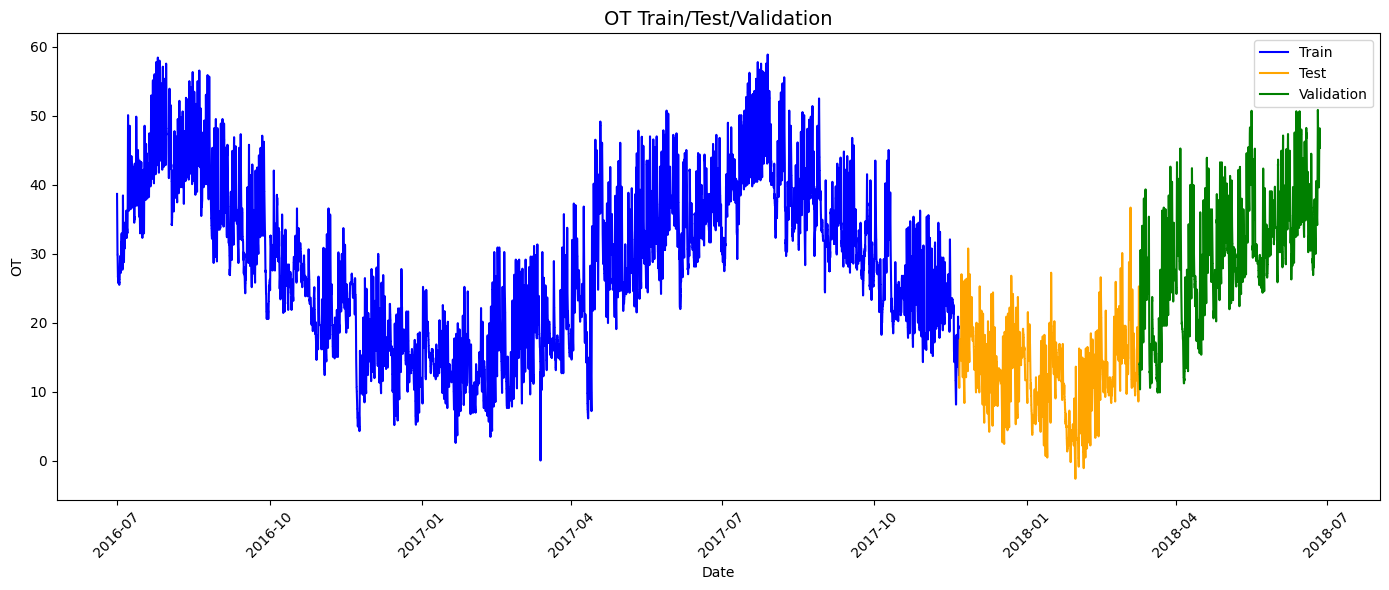

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

total_len = len(df)
train_size = int(0.7 * total_len)
val_size = int(0.15 * total_len)

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:train_size + val_size]
val_data = df.iloc[train_size + val_size:]

plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data["OT"], label='Train', color='blue', linewidth=1.5)
plt.plot(test_data.index, test_data["OT"], label='Test', color='orange', linewidth=1.5)
plt.plot(val_data.index, val_data["OT"], label='Validation', color='green', linewidth=1.5)
plt.title("OT Train/Test/Validation", fontsize=14)
plt.xlabel("Date")
plt.ylabel("OT")
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

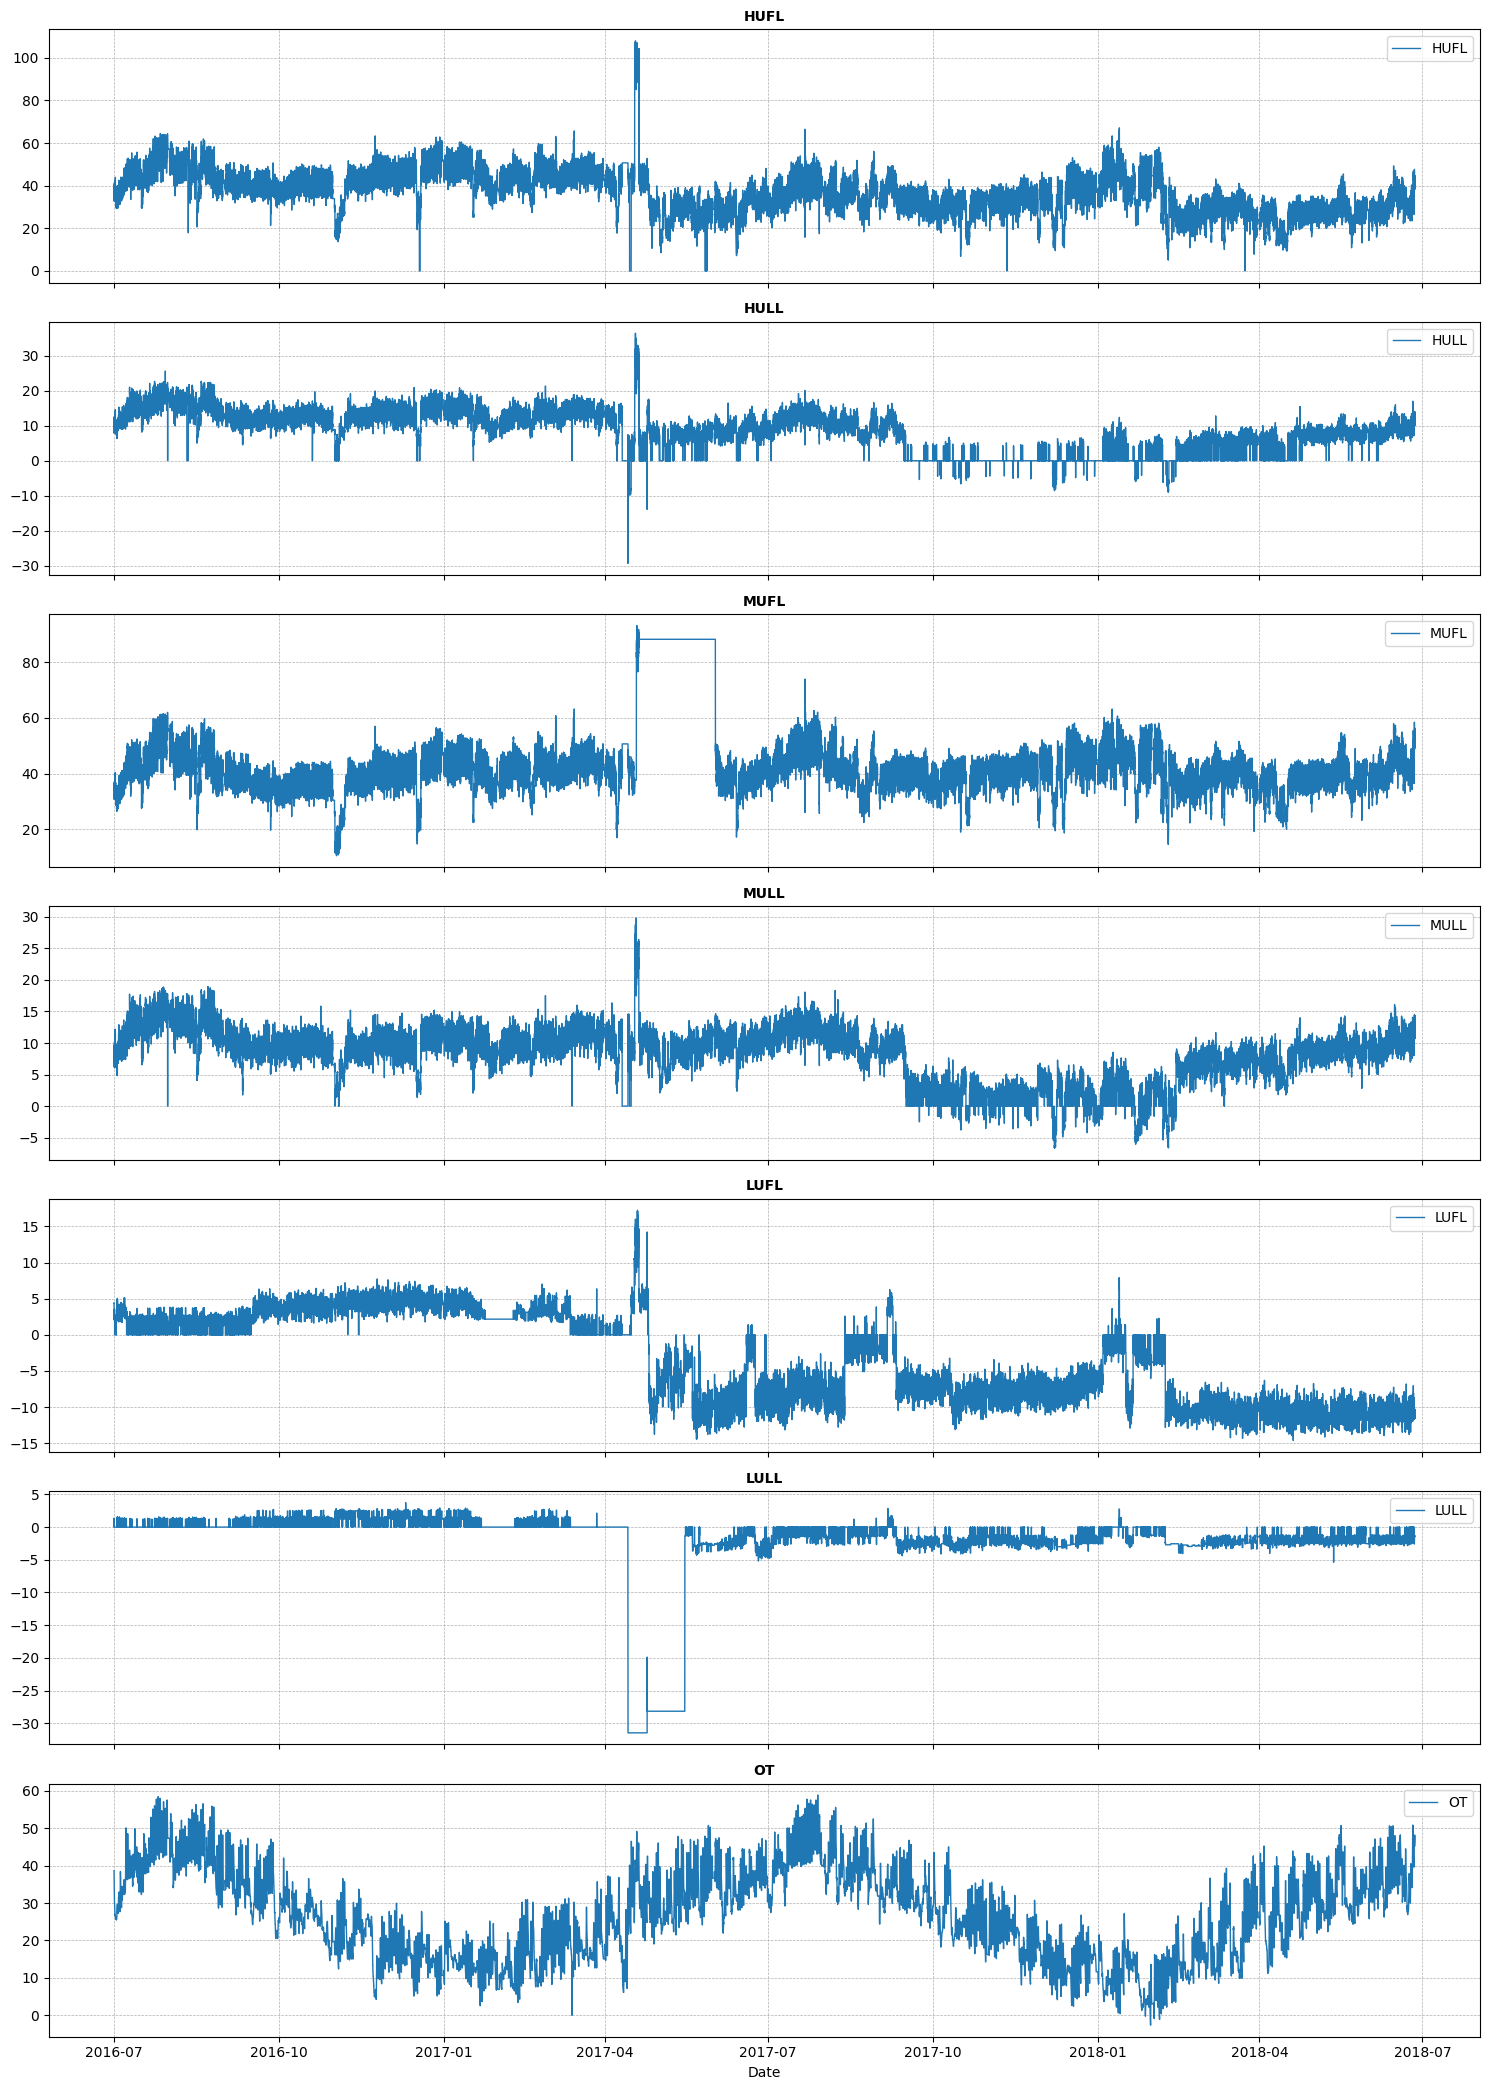

In [3]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

features = df.columns
n_features = len(features)
fig, axes = plt.subplots(nrows=n_features, ncols=1, figsize=(15, 3 * n_features), sharex=True)

for ax, feature in zip(axes, features):
    ax.plot(df.index, df[feature], label=feature, linewidth=1)
    ax.set_title(feature, fontsize=10, fontweight='bold')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend(loc='upper right')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

# ⚙️ Data Processing Strategy

* **Correction of Negatives (`abs`)**: Visual analysis reveals a sudden shift to negative values, likely due to a sensor polarity inversion. I will apply `abs()` to restore the correct magnitude.
* **Rolling Z-Score**: I chose local normalization rather than global. This method is robust to sensor sensitivity changes over time.
* **Variance Stabilization (`arcsinh`)**: Finally, I will apply an `arcsinh` transformation to stabilize the variance and ensure stationarity.

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler

df.reset_index()
df['date'] = pd.to_datetime(df['date'])

df['day_cos'] = np.cos((2 * np.pi * df['date'].dt.dayofweek) / 7)
df['day_sin'] = np.sin((2 * np.pi * df['date'].dt.dayofweek) / 7)
df['month_cos'] = np.cos((2 * np.pi * df['date'].dt.month) / 12)
df['month_sin'] = np.sin((2 * np.pi * df['date'].dt.month) / 12)

minutes_in_day = df['date'].dt.hour * 60 + df['date'].dt.minute
df['time_cos'] = np.cos(2 * np.pi * minutes_in_day / 1440)
df['time_sin'] = np.sin(2 * np.pi * minutes_in_day / 1440)

def process_feature(df, col_name, train_limit, window_size=336, use_abs=True, clip_threshold=None):

    if use_abs:
        series = df[col_name].abs()
    else:
        series = df[col_name].copy()

    roll = series.rolling(window=window_size)
    mean = roll.mean()
    std = roll.std()

    local_norm = (series - mean) / (std + 1)

    if clip_threshold is not None:
        local_norm = local_norm.clip(-clip_threshold, clip_threshold)

    arcsinh_val = np.arcsinh(local_norm)

    scaler = RobustScaler()
    train_values = arcsinh_val.iloc[:train_limit].dropna().values.reshape(-1, 1)

    scaler.fit(train_values)
    final_values = scaler.transform(arcsinh_val.values.reshape(-1, 1))

    new_col_name = f"{col_name}_final"
    df[new_col_name] = final_values.flatten()


    return df

n = len(df)
train_size = int(0.7 * n)
val_size = int(0.15 * n)

W_SIZE = 14 * 24

features_config = [("HULL", True, None),("LUFL", True, None),("LULL", True, 3.5), ("MULL", True, None),("MUFL", False, None),("HUFL", False, None)]

for col_name, abs_val, clip_val in features_config:
    df = process_feature(df,col_name,train_limit=train_size,window_size=W_SIZE,use_abs=abs_val,clip_threshold=clip_val)

target_col = 'OT'
target_scaler = RobustScaler()

raw_target_train = df.iloc[:train_size][[target_col]]
target_scaler.fit(raw_target_train)

df['OT_scaled'] = target_scaler.transform(df[[target_col]])

feature_cols_final = [c for c in df.columns if "_final" in c] + \
                     ["day_cos", "day_sin", "month_sin", "month_cos", "time_cos", "time_sin"]

target_col_final = 'OT_scaled'

data_features = df[feature_cols_final].copy()
data_target = df[[target_col_final]].copy()

data_features.describe().loc[["mean", "std", "min", "max"]]

df_model = pd.concat([data_features , data_target ], axis = 1 )

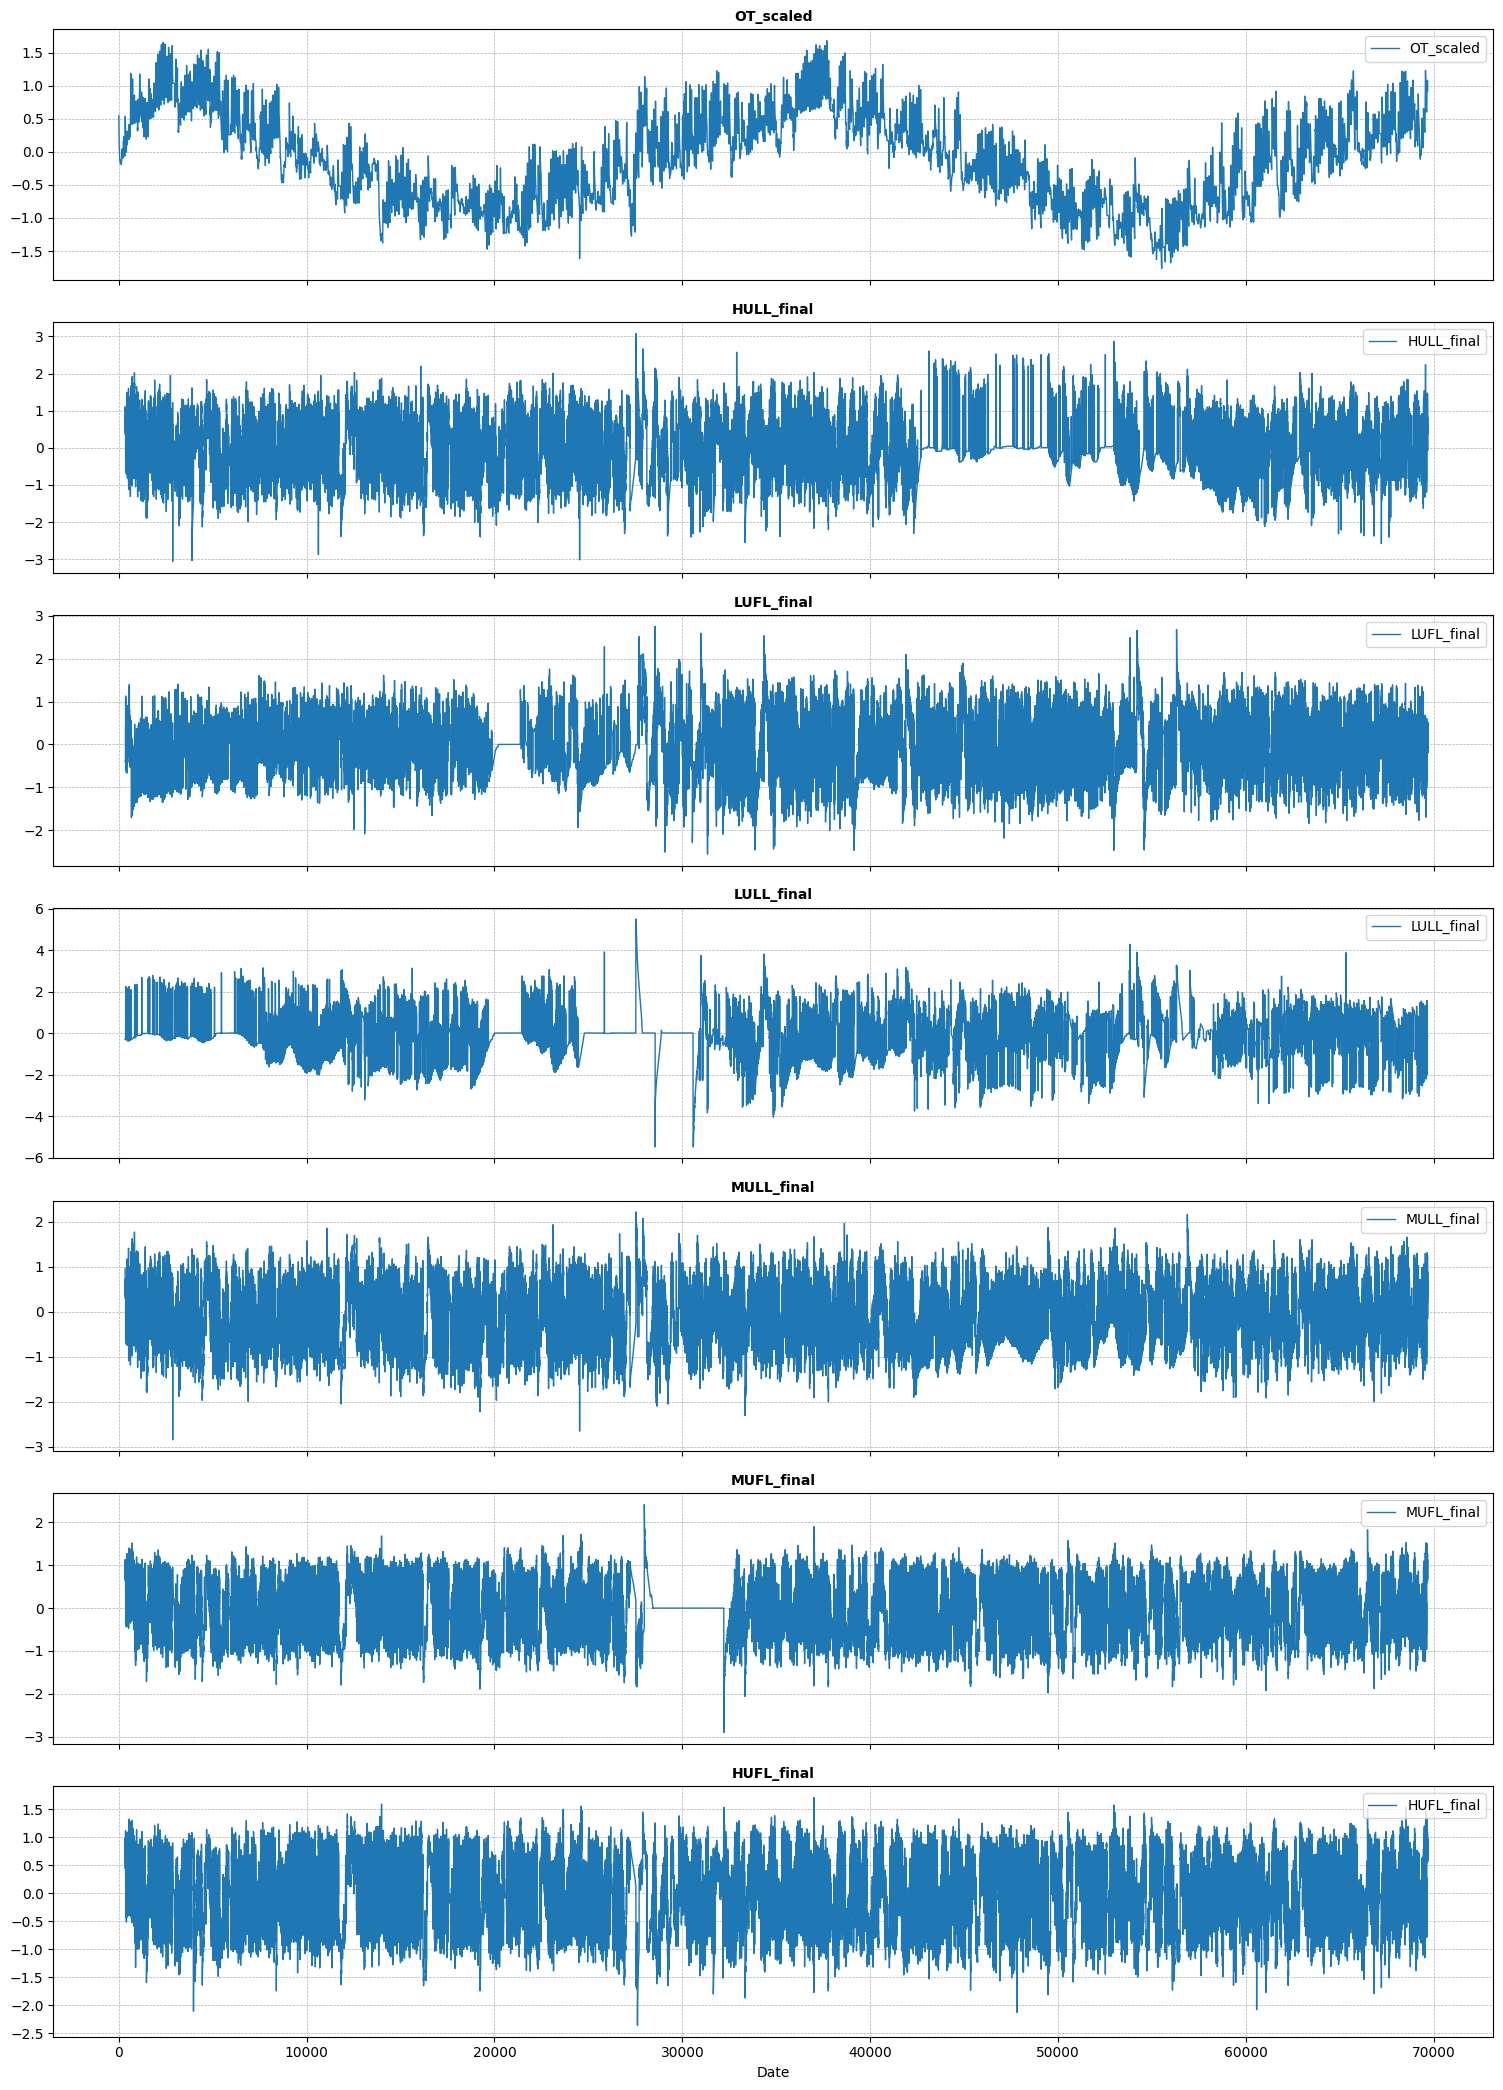

In [19]:
df_scaled = df[["OT_scaled" , "HULL_final" , "LUFL_final","LULL_final" , "MULL_final", "MUFL_final" , "HUFL_final"]].copy()


features = df_scaled.columns
n_features = len(features)
fig, axes = plt.subplots(nrows=n_features, ncols=1, figsize=(15, 3 * n_features), sharex=True)

for ax, feature in zip(axes, features):
    ax.plot(df_scaled.index, df_scaled[feature], label=feature, linewidth=1)
    ax.set_title(feature, fontsize=10, fontweight='bold')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend(loc='upper right')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [22]:
from src.data_loaders import create_loaders


df_model = df_model.dropna()

seq_length = 96
pred_length = 96
batch_size = 32

train_loader, val_loader, test_loader, target_idx = create_loaders(df_model, seq_length=seq_length, pred_length=pred_length, batch_size=batch_size, target_col_name='OT_scaled')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_batch = next(iter(train_loader))
input_size = sample_batch[0].shape[-1]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from itertools import product
from src.train_utils import one_epoch

param_grid = {'switch': [True],'weight_decay': [0.0005],'bias_R': [5.75 , 5.5 ,5],'cell_dim': [32 , 48 , 64],'lr': [0.001] , "dropout" : [0.2]}

combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
results = []

MIN_RELEASES = 0
MAX_RELEASES = 7000
idx = 0

for combo in combinations:

    params = dict(zip(param_names, combo))
    seed = 42 + idx
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    print(f"Seed {seed}")
    print(f"\nTesting: Wd={params['weight_decay']}, Cell={params['cell_dim']}, "
          f"Switch={params['switch']}, Bias_R={params['bias_R']}, Lr={params['lr']}, Dropout={params['dropout']}")


    model = PETNN(input_size=input_size,hidden_size=64,cell_dim=params['cell_dim'],hard_switch=params['switch'],Rt_bias=params['bias_R'],dropout=params["dropout"], forecast_horizon=pred_length).to(device)

    criterion =nn.HuberLoss(delta=1.0)
    optimizer = torch.optim.Adam(model.parameters(),lr=params['lr'],weight_decay=params['weight_decay'])
    skipped = False
    num_epochs = 3
    for epoch_num in range(num_epochs):
        train_loss, val_loss, avg_releases = one_epoch(model, train_loader, val_loader, optimizer, criterion, device)

        if params['switch']:
            print(f"Epoch {epoch_num+1}: Train={train_loss:.6f}, Val={val_loss:.6f}, Avg Releases={avg_releases:.2f}")
        if avg_releases < MIN_RELEASES or avg_releases > MAX_RELEASES:
            print(f"  -> Skipping. Avg Releases ({avg_releases:.2f}) not in [{MIN_RELEASES}, {MAX_RELEASES}].")
            skipped = True
            break

    if not skipped:
        gap = train_loss - val_loss
        loss_final = val_loss + gap
        results.append({**params,'final_train_loss': train_loss,'final_val_loss': val_loss,'loss': loss_final})
    else:
        results.append({**params, 'loss': float('inf')})
    idx += 1
best_result = min(results, key=lambda x: x['loss'])

Seed 42

Testing: Wd=0.0005, Cell=32, Switch=True, Bias_R=5.75, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.035378, Val=0.039838, Avg Releases=3.29
Epoch 2: Train=0.023306, Val=0.034099, Avg Releases=2.14
Epoch 3: Train=0.022087, Val=0.029997, Avg Releases=1.41
Seed 43

Testing: Wd=0.0005, Cell=48, Switch=True, Bias_R=5.75, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.035113, Val=0.029733, Avg Releases=0.12
Epoch 2: Train=0.023766, Val=0.033970, Avg Releases=0.00
Epoch 3: Train=0.022825, Val=0.039456, Avg Releases=0.00
Seed 44

Testing: Wd=0.0005, Cell=64, Switch=True, Bias_R=5.75, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.035746, Val=0.038721, Avg Releases=0.00
Epoch 2: Train=0.024494, Val=0.034065, Avg Releases=0.00
Epoch 3: Train=0.023732, Val=0.029607, Avg Releases=0.00
Seed 45

Testing: Wd=0.0005, Cell=32, Switch=True, Bias_R=5.5, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.034134, Val=0.032709, Avg Releases=2.10
Epoch 2: Train=0.023561, Val=0.036084, Avg Releases=2.22
Epoch 3: Train=0.021878, Val=0

In [24]:
from src.train_utils import one_epoch

torch.manual_seed(45)
torch.cuda.manual_seed(45)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model_1 = PETNN(input_size=input_size,hidden_size=64,cell_dim=32,hard_switch=True,Rt_bias=5.5 ,dropout= 0.2, forecast_horizon=pred_length).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
patience = 3
patience_counter = 0

for epoch_num in range(15):
    train_loss, val_loss, avg_releases = one_epoch(model_1, train_loader, val_loader, optimizer, criterion, device)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch_num + 1
        best_model_state = {'epoch': epoch_num + 1,'model_state_dict': model_1.state_dict(),'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,'val_loss': val_loss,'avg_releases': avg_releases}
        torch.save(best_model_state, 'best_model.pth')
        patience_counter = 0
        print(f"New best!")
    else:
        patience_counter += 1
        print(f"No improvement ({patience_counter}/{patience})")

    print(f"Epoch {epoch_num+1}: Train={train_loss:.6f}, Val={val_loss:.6f}, Avg Releases={avg_releases:.2f}")
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch_num+1} epochs")
        break

print(f"\n=== Best model ===")
print(f"Epoch: {best_epoch}")
print(f"Train Loss: {best_model_state['train_loss']:.6f}")
print(f"Val Loss: {best_model_state['val_loss']:.6f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best!
Epoch 1: Train=0.187070, Val=0.185303, Avg Releases=1.27
No improvement (1/3)
Epoch 2: Train=0.153112, Val=0.185821, Avg Releases=0.82
New best!
Epoch 3: Train=0.148698, Val=0.178550, Avg Releases=0.48
New best!
Epoch 4: Train=0.146350, Val=0.172744, Avg Releases=0.17
No improvement (1/3)
Epoch 5: Train=0.142863, Val=0.173491, Avg Releases=0.06
No improvement (2/3)
Epoch 6: Train=0.140116, Val=0.190345, Avg Releases=0.08
No improvement (3/3)
Epoch 7: Train=0.137622, Val=0.178935, Avg Releases=0.05

Early stopping triggered after 7 epochs

=== Best model ===
Epoch: 4
Train Loss: 0.146350
Val Loss: 0.172744


In [25]:
from src.train_utils import  evaluate_model

model_1.eval()
result = evaluate_model(model_1, test_loader, target_scaler, device)

MSE=19.974029541015625
MAE=3.3229522705078125
RMSE=4.469231426209167


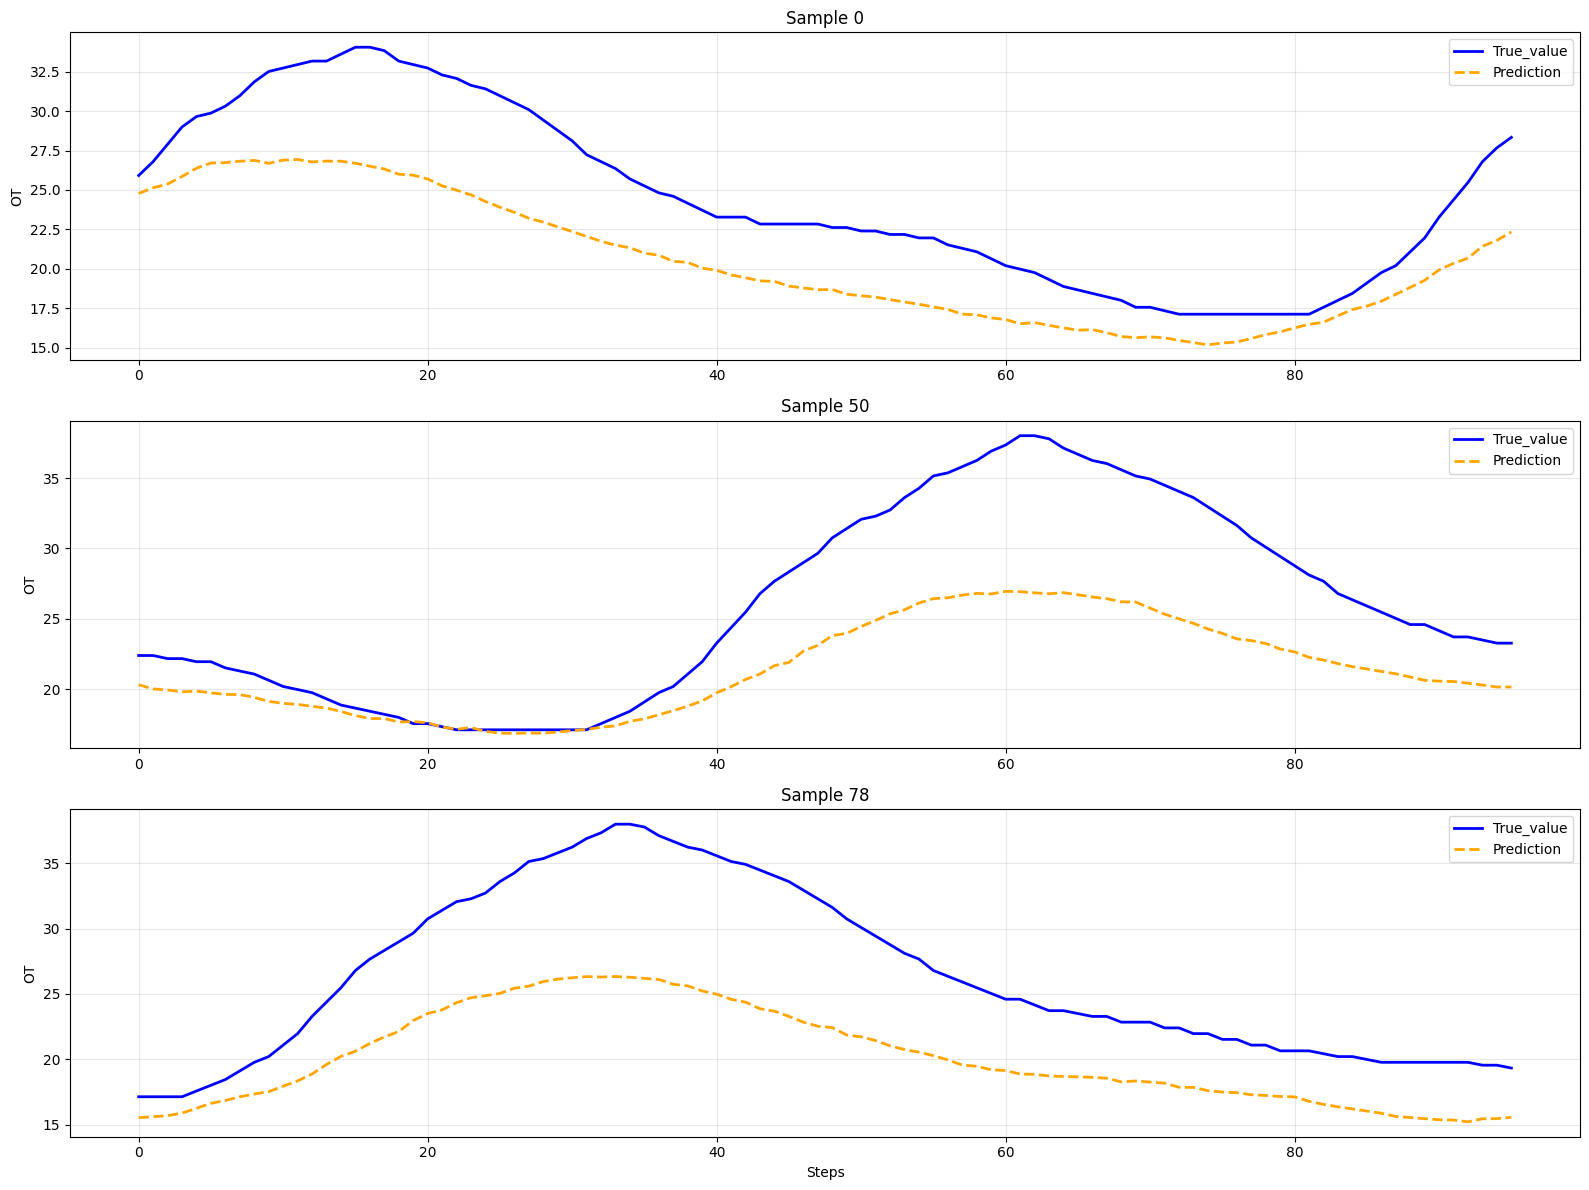

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

indices_to_plot = [0 , 50 , 78]

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

for i, idx in enumerate(indices_to_plot):
    if idx >= len(result["targets"]):
        print(f"Warning: index {idx} out of range")
        continue

    sample_y = result["targets"][idx].flatten()
    sample_y_pred = result["predictions"][idx].flatten()

    axes[i].plot(range(len(sample_y)), sample_y, label='True_value', color='blue', linewidth=2)
    axes[i].plot(range(len(sample_y_pred)), sample_y_pred, label='Prediction', color='orange', linewidth=2, linestyle='--')
    axes[i].set_title(f"Sample {idx}", fontsize=12)
    axes[i].set_ylabel("OT")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

axes[2].set_xlabel("Steps")
plt.tight_layout()
plt.show()

/tmp/ipython-input-2619475883.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


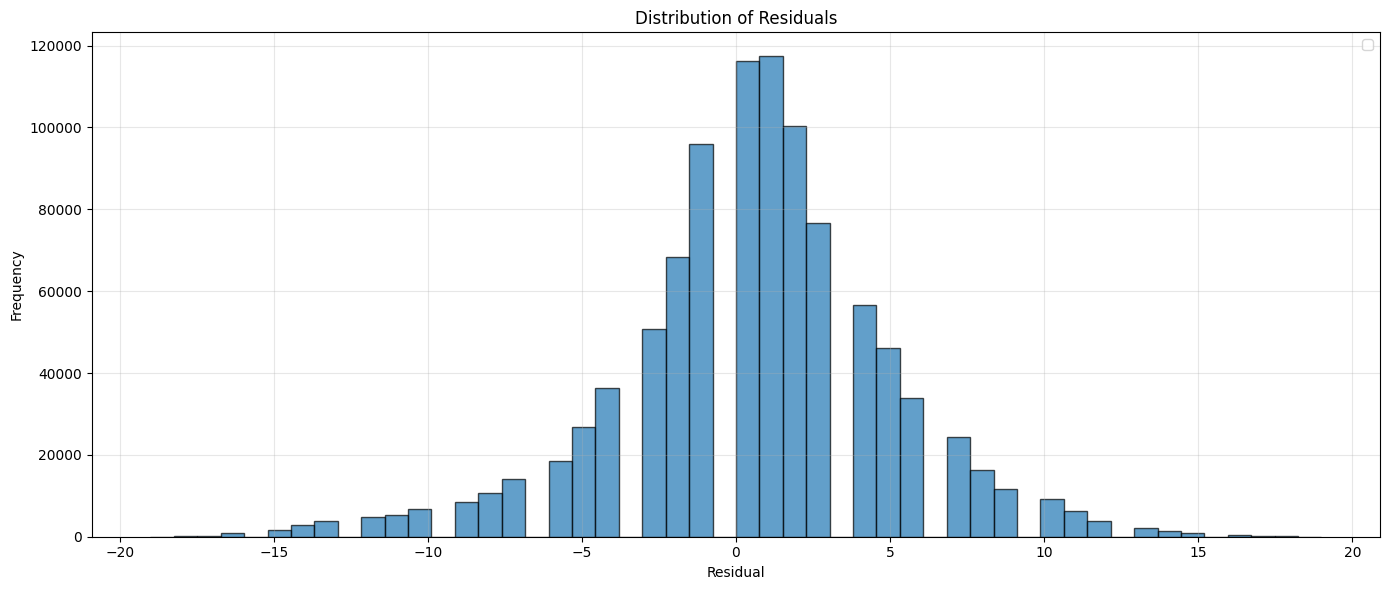

In [26]:
from src.train_utils import plot_residuals_distribution

residuals = plot_residuals_distribution(result)

In [27]:
residuals.mean()

np.float32(0.5585465)

In [ ]:
from itertools import product

param_grid = {'switch': [False],'weight_decay': [0.0005],'bias_R': [5.75 , 5.5 ,5],'cell_dim': [32 , 48 , 64],'lr': [0.001] , "dropout" : [0.2]}

combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
results = []

idx = 0

for combo in combinations:

    params = dict(zip(param_names, combo))
    seed = 42 + idx
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    print(f"Seed {seed}")
    print(f"\nTesting: Wd={params['weight_decay']}, Cell={params['cell_dim']}, "
          f"Switch={params['switch']}, Bias_R={params['bias_R']}, Lr={params['lr']}, Dropout={params['dropout']}")


    model = PETNN(input_size=input_size,hidden_size=64,cell_dim=params['cell_dim'],hard_switch=params['switch'],Rt_bias=params['bias_R'],dropout=params["dropout"], forecast_horizon=pred_length).to(device)

    criterion =nn.HuberLoss(delta=1.0)
    optimizer = torch.optim.Adam(model.parameters(),lr=params['lr'],weight_decay=params['weight_decay'])

    skipped = False
    num_epochs = 3
    for epoch_num in range(num_epochs):
        train_loss, val_loss, avg_releases = one_epoch(model, train_loader, val_loader, optimizer, criterion, device)
        print(f"Epoch {epoch_num+1}: Train={train_loss:.6f}, Val={val_loss:.6f}, Avg Releases={avg_releases:.2f}")

    if not skipped:
        gap = train_loss - val_loss
        loss_final = val_loss + gap
        results.append({**params,'final_train_loss': train_loss,'final_val_loss': val_loss,'loss': loss_final})
    else:
        results.append({**params, 'loss': float('inf')})
    idx += 1
best_result = min(results, key=lambda x: x['loss'])

Seed 42

Testing: Wd=0.0005, Cell=32, Switch=False, Bias_R=5.75, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.039998, Val=0.037509, Avg Releases=0.00
Epoch 2: Train=0.024938, Val=0.033416, Avg Releases=0.00
Epoch 3: Train=0.024390, Val=0.037764, Avg Releases=0.00
Seed 43

Testing: Wd=0.0005, Cell=48, Switch=False, Bias_R=5.75, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.039185, Val=0.030781, Avg Releases=0.00
Epoch 2: Train=0.024323, Val=0.035827, Avg Releases=0.00
Epoch 3: Train=0.023416, Val=0.046571, Avg Releases=0.00
Seed 44

Testing: Wd=0.0005, Cell=64, Switch=False, Bias_R=5.75, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.039870, Val=0.036723, Avg Releases=0.00
Epoch 2: Train=0.025708, Val=0.035812, Avg Releases=0.00
Epoch 3: Train=0.025335, Val=0.033685, Avg Releases=0.00
Seed 45

Testing: Wd=0.0005, Cell=32, Switch=False, Bias_R=5.5, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.038467, Val=0.048583, Avg Releases=0.00
Epoch 2: Train=0.024793, Val=0.035565, Avg Releases=0.00
Epoch 3: Train=0.023666, V

## Hard Switch vs Smooth Switch

The model performed significantly better before, when using the hard switch. This suggests that following the physics assumption meaning the physics inspired neural network is really important and the primary reason for the results shown.

However, this architecture suffers from the same issues as classical RNNs or LSTMs it is very slow to train, even though it is a small model. Given its performance, it can be discouraging to train it on large amounts of data.